# PyROOT Basics

Let's import ROOT first and initialise interactive environment.

In [1]:
import ROOT
%jsroot on

Welcome to JupyROOT 6.28/00


For non-interactive use, the following lines should be at the very top of the python file:
```
import ROOT
ROOT.gROOT.SetBatch(True)
```

## Root Trees

A ROOT file with simulated Z->μμ events is prepared for you. Let's open it and get a `TTree` with the physics content out of it.

In [2]:
from ROOT import TFile
file = TFile("Zmumu.root")
tree = file.Get("physics")

To get familiarised with the contents of a file we can get number of entries and the content of one event.

In [3]:
print(f"Entries: {tree.GetEntries()}")
tree.Show(123)

Entries: 2500000
======> EVENT:123
 lep1_pt         = 36.6134
 lep1_eta        = 1.72734
 lep1_phi        = 2.45882
 lep1_E          = 106.242
 lep1_m          = 0.102701
 lep2_pt         = 24.3234
 lep2_eta        = 0.999867
 lep2_phi        = -0.616201
 lep2_E          = 37.5293
 lep2_m          = 0.105446
 Z_pt            = 12.4495
 Z_eta           = 3.02829
 Z_phi           = 2.32848
 Z_E             = 143.771
 Z_m             = 63.6461


We can also scan through the tree and get a matrix of the quantities. We can pass the following arguments:
- variables to list (e.g. `lep1_pt:lep2_pt:Z_pt`)
- selection to apply (e.g. `Z_m > 200`)
- options (let's skip this for now)
- important for python: number of entries and first entry (otherwise the whole tree will get printed)

In [4]:
tree.Scan("lep1_pt:lep2_pt:Z_pt", "", "", 10, 1000)

10

************************************************
*    Row   *   lep1_pt *   lep2_pt *      Z_pt *
************************************************
*     1000 * 28.552259 * 24.640493 * 29.956617 *
*     1001 * 46.691467 * 32.588851 * 20.080736 *
*     1002 * 51.384120 * 23.717432 * 30.551261 *
*     1003 * 51.648632 * 42.388435 * 93.866516 *
*     1004 * 43.037010 * 40.113140 * 3.7478344 *
*     1005 * 46.186592 * 43.645080 * 9.5110168 *
*     1006 * 51.771820 * 35.814361 *  16.38661 *
*     1007 * 30.069040 * 20.602933 * 9.9353952 *
*     1008 * 42.196514 * 37.382263 * 5.1595315 *
*     1009 * 51.599880 * 11.514470 * 46.104538 *
************************************************


In [5]:
tree.Scan("lep1_pt:lep2_pt:Z_pt", "Z_m > 200", "", 1000, 1000)

3

************************************************
*    Row   *   lep1_pt *   lep2_pt *      Z_pt *
************************************************
*     1213 * 139.37292 * 87.473121 * 66.915741 *
*     1341 * 116.42005 * 39.788391 * 81.070587 *
*     1844 * 85.993904 * 64.176918 * 28.775011 *
************************************************
==> 3 selected entries


### Useful `TTree` functions

| Command        | Action     |
| :------------ | :-------  |
| `tree.Print()` | prints the content of the tree |
| `tree.Scan()` | scans the rows and columns |
| `tree.Draw("x")` | draw a branch of tree `x` |
| `tree.Draw("x", "x > 0")` | draw `x` when `x > 0` |
| `tree.Draw("x", "x > 0 && y > 0")` | draw `x` when both `x > 0` and `y > 0` |
| `tree.Draw("y", "", "same")` | uperimpose `y` on `x` |
| `tree.Draw("y:x")` | make `y` vs `x` 2D scatter plot |
| `tree.Draw("z:y:x")` | make `z:y:x` 3D plot |
| `tree.Draw("sqrt(x*x + y*y)")` | plot calculated quantity |
| `tree.Draw("x>>h1")`  | dump a root branch to a histogram |
| more... | [TTree documentation](https://root.cern.ch/doc/master/classTTree.html) |

## Drawing/Plotting Tree Content

Now let's plot a few variables directly. Note that when using Jupyter I have to create a canvas to plot on first. This is not needed when running interactively.

In [6]:
from ROOT import TCanvas
canvas = TCanvas("canvas", "", 800, 450)

One can draw directly from a `TTree`. The available options are:
- the quantity to draw (e.g. `lep1_pt`)
- selection to apply (e.g. `lep1_pt < 1000`)
- drawing/plotting options

In [7]:
tree.Draw("lep1_pt")
canvas.Draw()

In [8]:
tree.Draw("lep1_pt", "lep1_pt < 250", "logy")
canvas.Draw()

In [9]:
tree.Draw("lep1_pt:lep2_pt", "lep1_pt < 500 && lep2_pt < 500", "colz")
canvas.Draw()

In [10]:
# we want to hide statistics box from now on
from ROOT import gStyle
gStyle.SetOptStat(0)

As we have seen ROOT makes assumptions how to make a histogram, mainly binning and axis ranges.

Let's create a histogram manually. Usually one uses `TH1D` which has double precision. Even if our quantities are not very precise, the precision matters if we have a lot of events (which is usually the case in HEP).

The options for `TH1D` are:
- name/identifier
- title (used for display, limited LaTeX support present)
- number of bins
- minimum bin edge
- maximum bin edge

In [11]:
from ROOT import TH1D
hist = TH1D("hist_lep1_pt", "Leading lepton p_{T}", 50, 0, 500)
tree.Draw("lep1_pt >> hist_lep1_pt", "", "logy")
canvas.Draw()

Often we want to do more complex data manipulations. In such case we loop the tree and fill the histogram(s) manually.

Notes:
- This loads the whole file by default, even the variables we are not iterested in.
- In this example we will reuse the lepton pT histogram so we call `hist.Clear()` first.

In [12]:
hist.Clear()
hist_sum = TH1D("hist_lep_pt_sum", "Scalar sum of lepton p_{T}", 50, 0, 500)
hist_sum.Sumw2()  # for proper error handling

for entry in tree:
  hist.Fill(entry.lep1_pt)
  hist_sum.Fill(entry.lep1_pt + entry.lep2_pt, 0.95)

In [13]:
hist.Draw("hist logy PLC")      # PLC automatically chooses colors
hist_sum.Draw("hist same PLC")  # to draw on same canvas
canvas.Draw()

If we want to save to a file, we can make a new file and write the histogram to it.

In [14]:
with TFile("output.root", "recreate") as f:  # or "update" if you want to write to an existing file
  hist_sum.Write()  # write histogram to file
  f.WriteObject(hist, "hist_custom")  # write histogram to file with custom name

### Useful `TH1` functions

| Command        | Action     |
| :------------ | :-------  |
| `hist.GetMean()` | mean of a histogram |
| `hist.GetRMS()` | RMS of a histogram |
| `hist.GetBinContent(i)` | content of a bin with index `i` |
| `hist.GetBinError(i)` | uncertainty of a bin with index `i` |
| `hist.GetMaximum()` | maximum value of the histogram |
| `hist.GetMaximumBin()` | the bin with the maximum value |
| `hist.Integral()` | integral of the histogram |
| `hist.GetXaxis()` | x-axis |
| `hist.GetYaxis()` | y-axis |
| more... | [TH1 documentation](https://root.cern.ch/doc/master/classTH1.html) |

## Exercise 1: Histogram Drawing

Write a python macro `ExerciseHist.py`.

1. Open the `Zmumu.root` file and load the tree called `physics`.
2. Create two histograms with 40 bins ranging from 0 to 0.2 GeV to plot the muon masses.
3. Fill the histograms with leading and subleading muon mass from branches `lep1_m` and `lep2_m`.
4. Calculate the mean values and RMSs.
5. Calculate the integrals.

Bonus questions:
1. Are the integrals the same and why?
2. Write the histogram to a file.

## Graphs

Graphs are used to display value pairs, errors can be defined to be either symmetric or antisymmetric.

In [15]:
from ROOT import TGraphAsymmErrors
# create graph with asymmetric errors with 3 points
graph = TGraphAsymmErrors(3)
# set the points and their errors
graph.SetPoint(0, 3.0, 2.1)
graph.SetPointError(0, 0.1, 0.2, 0.3, 0.4)
graph.SetPoint(1, 5.0, 2.9)
graph.SetPointError(1, 0.4, 0.3, 0.2, 0.1)
graph.SetPoint(2, 7.2, 3.5)
graph.SetPointError(2, 0.1, 0.1, 0.1, 0.1)
# set style
graph.SetMarkerStyle(21)
graph.SetMarkerSize(1)
# draw axis (A), points (L), and line (P)
graph.Draw("APL")
canvas.Draw()

### Useful `TGraph` functions

| Command        | Action     |
| :------------ | :-------  |
| [`TGraph(n)`](https://root.cern.ch/doc/master/classTGraph.html) | 1D graph without errors with `n` points |
| [`TGraphErrors(n)`](https://root.cern.ch/doc/master/classTGraphErrors.html) | 1D graph with symmetrical errors with `n` points |
| [`TGraphAsymmErrors(n)`](https://root.cern.ch/doc/master/classTGraphAsymmErrors.html) | 1D graph with asymmetrical errors with `n` points |
| `graph.SetPoint(i, x, y)` | set a point with index `i` with coordinates `x` and `y` |
| `graph.SetPointError(i, ex, ey)` | set symmetrical errors of a point with index `i` and values `ex` and `ey` |
| `graph.SetPointError(i, exl, exh, eyl, exh)` | set asymmetrical errors of a point with index `i` and values `exl`, `exh`, `eyl` and `eyh` |
| `graph.Fit("function")` | fit a function with name `function` |
| more... | click class constructor above |

## Functions

Classes for 1 to 3 dimensional functions: `TF1`, `TF2` and `TF3`.

One can use:
- predefined functions
- custom functions where `[n]` defines a `n`-th parameter
- full C++ functions (will not look at today)

In [16]:
from ROOT import TF1, kBlue
# use of predefined cuntions, e.g. "gaus", "pol1", "pol3"
f_gaus = TF1("f_gaus", "gaus", -2, 2)
f_gaus.SetParameter(0, 10)
f_gaus.SetParameter(1, 1)
f_gaus.SetParameter(2, 0.5)
# use of custom functions
f_custom = TF1("f_custom", "[0]*exp(-0.5*pow((x-[1])/[2], 2))", -2, 2)
f_custom.SetParameter(0, 5)
f_custom.SetParameter(1, 0)
f_custom.SetParameter(2, 1)
# make sure colors are different
f_custom.SetLineColor(kBlue)
# draw
f_gaus.Draw()
f_custom.Draw("same")
canvas.Draw()

Functions can be used to fit a `TGraph` or a `TH1`.

In [17]:
from ROOT import TF1, TH1D

f_fit = TF1("f_fit", "gaus", 70, 110)

hist_Z = TH1D("hist_Zmass", "Z boson mass", 80, 70, 110)
tree.Draw("Z_m >> hist_Zmass")

hist_Z.Fit("f_fit")  # note that this associates the function with the histogram

canvas.Draw()

 FCN=244801 FROM MIGRAD    STATUS=CONVERGED      87 CALLS          88 TOTAL
                     EDM=1.09943e-09    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   1.6 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.31588e+05   1.38812e+02  -1.20496e-01  -9.64144e-08
   2  Mean         9.06721e+01   2.25958e-03   4.18742e-07   2.07789e-02
   3  Sigma        3.23897e+00   2.59313e-03  -2.80403e-07  -2.12173e-01


### Useful `TF1` functions

| Command        | Action     |
| :------------ | :-------  |
| `graph.SetParameter(i, value)` | set parameter with index `i` and value `value` |
| `graph.GetParameter(i)` | get parameter with index `i` |
| `graph.GetParError(i)` | get parameter error with index `i` |
| `graph.SetLineColor(kRed)` | set line color (e.g. `kRed`) |
| more... | [TF1 documentation](https://root.cern.ch/doc/master/classTF1.html) |

## Exercise 2: Graphs and Fits

Write a python macro `ExerciseGraph.py`.

1. Create a graph with symmetric errors and 5 points.
2. Set the following points:
   `(1.0, 2.1), (2.0, 2.9), (3.0, 4.05), (4.0, 5.2), (5.0, 5.95)`
3. Set the errors on `x` to 0.0 and the errors on `y` to 0.1 (all at once).
4. Draw the graph including the axes and error bars.
5. Create a one dimensional function `f(x) = ax + b` and fit it to the graph.

Bonus questions:
1. Programatically obtain the two parameters `a` and `b` and their estimated uncertainties.

## Other Canvas Elements

One canvas can be reused to plot many items besides histograms, graphs and functions:
- legends
- labels
- lines
- arrows

Simple objects listed above do not require the `same` argument.

In [18]:
from ROOT import TLegend
legend = TLegend(0.7, 0.75, 0.90, 0.87)
legend.AddEntry(hist_Z, "simulation", "l")
legend.AddEntry(f_fit, "fit", "l")
legend.SetBorderSize(0)
legend.Draw()
canvas.Draw()

## Exercise 3: Canvas and Legends

Write a python macro `ExerciseCanvas.py`.

1. Create two histograms with 50 bins ranging from -3 to 3 with two different names.
2. Fill first histogram with Gaussian distribution with 10000 entries.
3. Fill second histogram with a second order polynomial and 5000 entries (hint: `hist2.FillRandom("pol2", 500)`).
4. Set the line color of the first histogram to `kRed` and second to `kBlue`.
5. Draw both histograms on a canvas.
6. Clone both histograms and normalise them (scale with inverse of the integral).
7. Draw both histograms on a different canvas.
8. Draw a legend on both canvases at position `(0.16, 0.63, 0.45, 0.91)`; bonus: do it after you created both canvases.
9. Save both canvases in a PDF; bonus: save them in the same file.

## Ratio plots

Often we want to plot ratio between two distributions (e.g. data and Monte Carlo or how well fit matches the distribution).

In [19]:
from ROOT import TH1D
hist_for_ratio = TH1D("hist_ratio", "hist", 50, -5, 5)
hist_for_ratio.FillRandom("gaus", 2000)
hist_for_ratio.Fit("gaus")
hist_for_ratio.GetXaxis().SetTitle("x")
canvas.Clear()  # Fit does not draw into correct pad

from ROOT import TRatioPlot
ratio_plot = TRatioPlot(hist_for_ratio)
ratio_plot.Draw()
ratio_plot.GetLowerRefYaxis().SetTitle("ratio")
ratio_plot.GetUpperRefYaxis().SetTitle("entries")
canvas.Draw()

 FCN=22.1778 FROM MIGRAD    STATUS=CONVERGED      54 CALLS          55 TOTAL
                     EDM=1.30715e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.58988e+02   4.47298e+00   8.40573e-03   1.35230e-04
   2  Mean         6.62197e-03   2.25355e-02   5.27819e-05  -8.76854e-04
   3  Sigma        9.93481e-01   1.69678e-02   1.05689e-05   9.41157e-02


But sometimes one ratio pad is not enough or we want to do it manually.

In [20]:
# it seems JSROOT is buggy with multiple pads, so we disable it for this example
%jsroot off

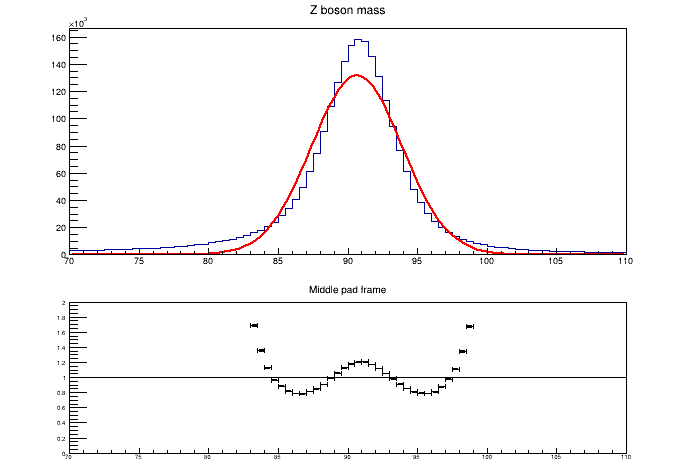

In [21]:
from ROOT import TGraphAsymmErrors

graph = TGraphAsymmErrors()
for i in range(1, hist_Z.GetNbinsX() + 1):
    y = hist_Z.GetBinContent(i)
    x = hist_Z.GetBinCenter(i)
    exh = exl = hist_Z.GetBinWidth(i) / 2

    graph.SetPoint(i - 1, x, y / f_fit.Eval(x))
    graph.SetPointError(i - 1, exl, exh, hist_Z.GetBinErrorLow(i) / f_fit.Eval(x), hist_Z.GetBinErrorUp(i) / f_fit.Eval(x))

from ROOT import TCanvas, TLine, TPad
canvas_pads = TCanvas("canvas_pads", "Double ratio")
pad_top = TPad("top_pad", "Top pad", 0, 0.4, 1, 1)
pad_top.Draw()
pad_bottom = TPad("bottom_pad", "Bottom pad", 0, 0, 1, 0.4)
pad_bottom.Draw()

pad_top.cd()
hist_Z.Draw()

pad_bottom.cd()
frame_bottom = pad_bottom.DrawFrame(hist_Z.GetBinLowEdge(1), 0, hist_Z.GetBinLowEdge(hist_Z.GetNbinsX() + 1), 2, "Middle pad frame");
line = TLine(hist_Z.GetBinLowEdge(1), 1, hist_Z.GetBinLowEdge(hist_Z.GetNbinsX() + 1), 1)
line.Draw("same")
graph.Draw("P same")
pad_bottom.Update()
pad_bottom.RedrawAxis()

canvas_pads.Draw()

Unfortunately "ROOT plotting math" is quite complex. We will use a simple example to demonstrate the idea. Label sizes are relative to the height (and width) of the pad so we need to rescale the values to the size of the pad. As width is constant in our example we only take the fractions of the height and divide by it.

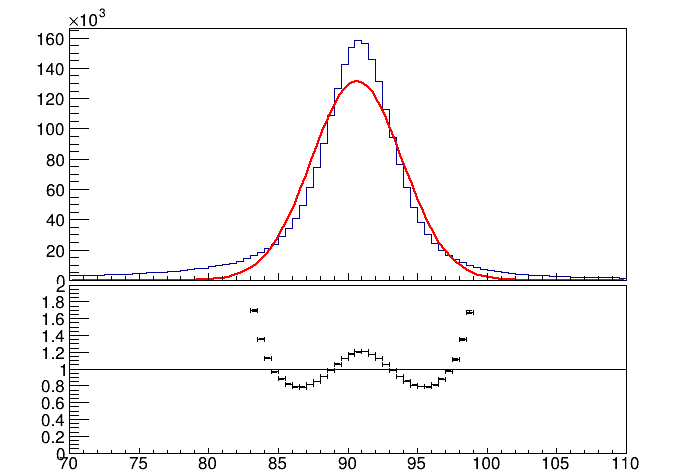

In [22]:
pad_top.SetBottomMargin(0.01)
pad_bottom.SetTopMargin(0.01)
hist_Z.SetTitle("")
hist_Z.GetXaxis().SetLabelSize(0)
hist_Z.GetYaxis().SetLabelSize(0.04/0.6)
frame_bottom.SetTitle("")
frame_bottom.GetXaxis().SetLabelSize(0.04/0.4)
frame_bottom.GetYaxis().SetLabelSize(0.04/0.4)
canvas_pads.Draw()